In [1]:
import os
import zipfile
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt


In [2]:
base_dir = 'E:\Diabetic Retinopathy'


# E:\Diabetic Retinopathy\Train
train_dir = os.path.join(base_dir, 'Train')

# E:\Diabetic Retinopathy\Test
test_dir = os.path.join(base_dir, 'Test')

# train directory with our negative test results
# E:\Diabetic Retinopathy\Train\0
train_neg_dir = os.path.join(train_dir, '0')

# train directory with our positive test results
# E:\Diabetic Retinopathy\Train\Db_positive
train_pos_dir = os.path.join(train_dir, 'Db_positive')

# test directory with our negative test results
# E:\Diabetic Retinopathy\Test\0
test_neg_dir = os.path.join(test_dir, '0')

# test directory with our positive test results
# E:\Diabetic Retinopathy\Test\Db_positive
test_pos_dir = os.path.join(test_dir, 'Db_positive')

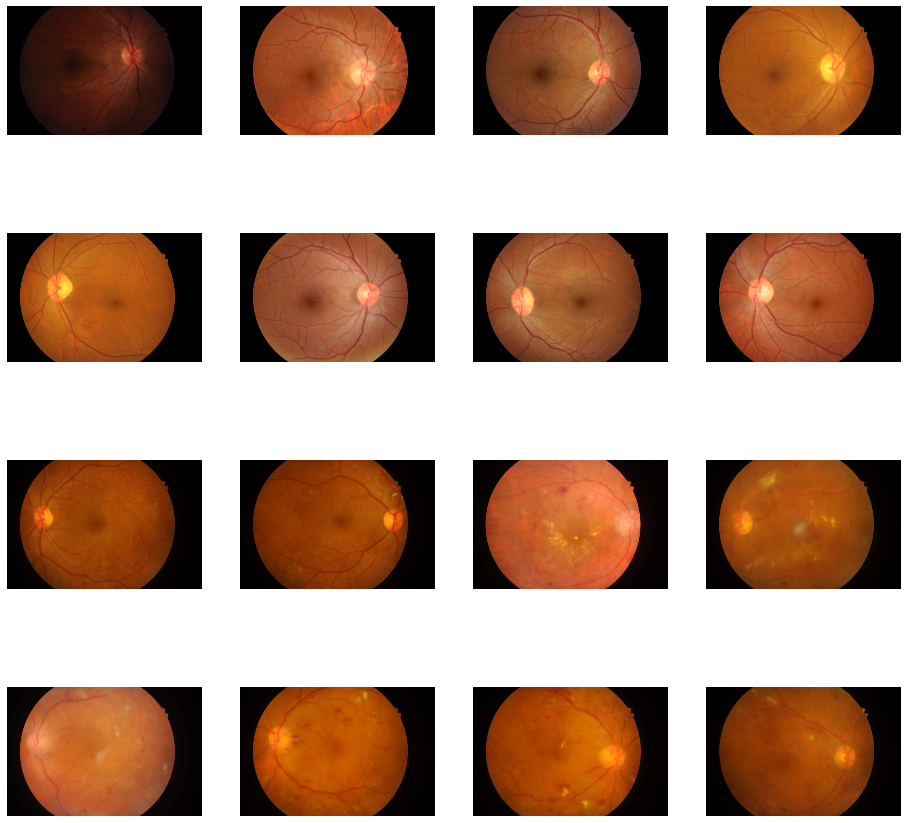

In [3]:
#TODO
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

# gets current figure of plt
fig = plt.gcf()
# sets width and height of each image in inches
fig.set_size_inches(ncols*4, nrows*4)
# a random pic index
pic_index = 100

# gets a list of all negative images in train_neg_dir
train_neg_fnames = os.listdir(train_neg_dir)
# gets a list of all positive images in train_pos_dir
train_pos_fnames = os.listdir(train_pos_dir)

# gets list of next negative pics
# by joining filename with directory
next_neg_pix = [os.path.join(train_neg_dir, fname)
                for fname in train_neg_fnames[pic_index - 8:pic_index]
                ]

# gets list of next positive pics
# by joining filename with directory
next_pos_pix = [os.path.join(train_pos_dir, fname)
                for fname in train_pos_fnames[pic_index - 8:pic_index]
                ]

# enumerate converts a list to a list of tuples ie [(0, 001.jpg), (1, 002.jpg)]
for i, img_path in enumerate(next_neg_pix + next_pos_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

# displays plot
plt.show()

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
# Generate batches of tensor image data with real-time data augmentation.
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Takes the path to a directory & generates batches of augmented data.
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size = 20, class_mode ='binary', target_size = (150, 150))

# Instantiates the Inception v3 architecture.
# We will be using only the basic models, with changes made only to the final layer.
# This is because this is just a binary classification problem while these models are built to handle up to 1000 classes.
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

# Since we don’t have to train all the layers, we make them non-trainable
for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.optimizers import RMSprop

# Flatten the output of our base model to 1 dimension
x = layers.Flatten()(base_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

hist = model.fit(train_generator, validation_data = test_generator, steps_per_epoch = 20, epochs = 50)
#model.summary()

Found 413 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()